Shape X_seq: (17282, 10, 3)
Shape y_seq: (17282, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.6249 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 2/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4115 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 3/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3356 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 4/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3082 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 5/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2502 - val_loss: 0.1945 - learning_rate: 0.0010
Epoch 6/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2224 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 7/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2289 - val_loss: 0.1653 - learning_rate: 0.0010
Epoch 8/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1926 - val_loss: 0.1594 - learning_rate: 0.0010
Epoch 9/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2063 - val_loss: 0.1570 - learning_rate: 0.001

433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


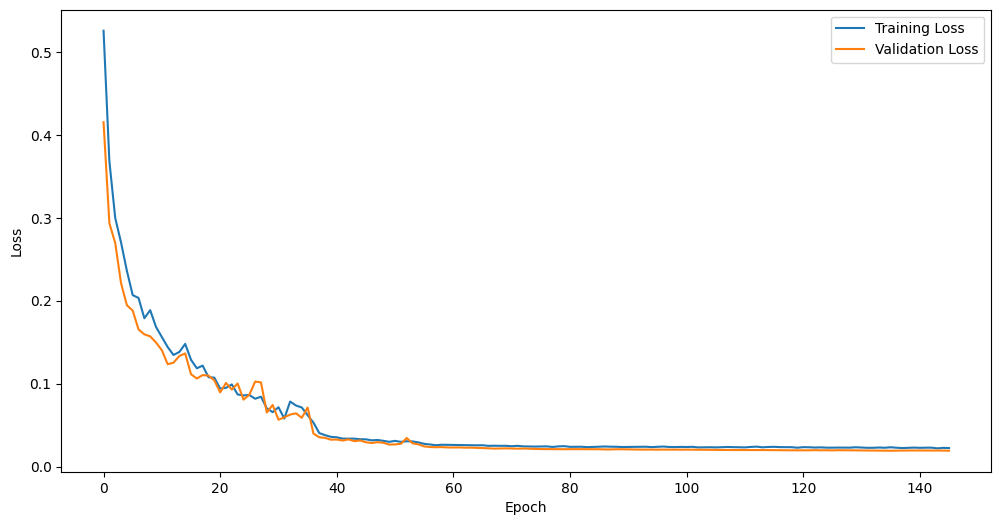

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE Fx: 0.15986516990164837, R² Fx: 0.9839249775802997
MSE Fy: 0.3645889626246089, R² Fy: 0.9841399987467252
MSE Fz: 2.7200844772166723, R² Fz: 0.9755422195810928


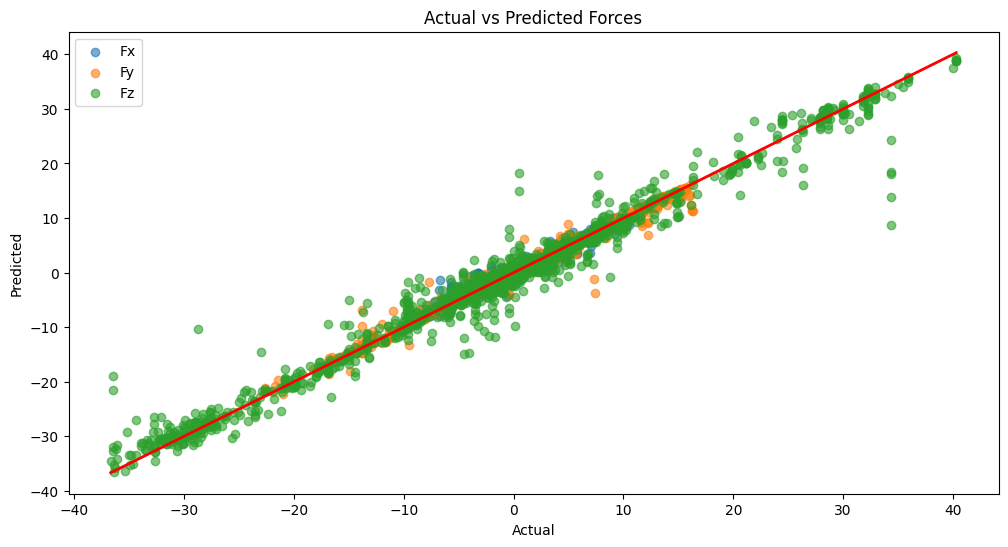

MSE Fx (SVM): 0.01603724042975342, R² Fx (SVM): 0.9839519139452474
MSE Fy (SVM): 0.01520095770713454, R² Fy (SVM): 0.9848098300242012
MSE Fz (SVM): 0.02543089085491673, R² Fz (SVM): 0.9754343258213919


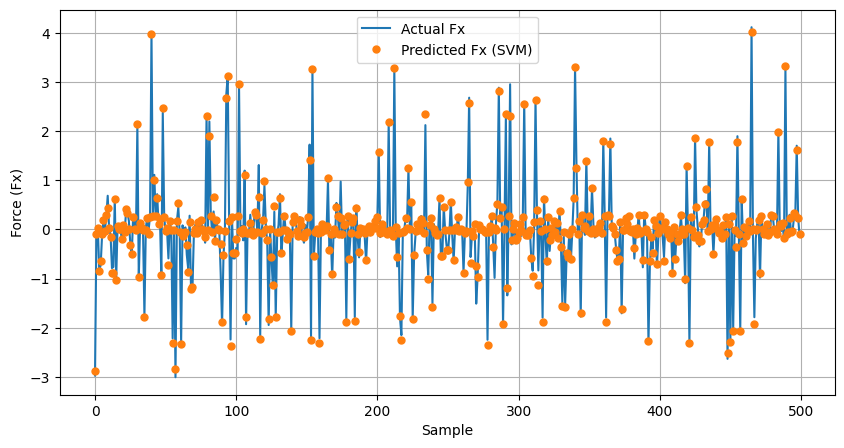

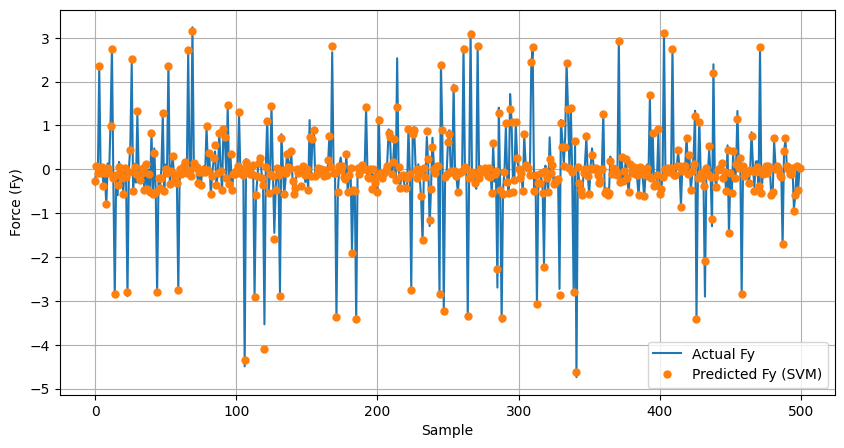

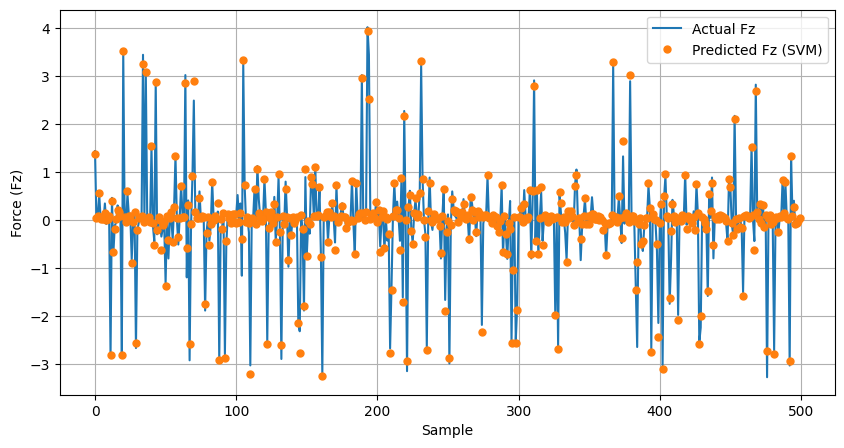

['svm_fz.pkl']

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import random
import tensorflow as tf

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)  # Seed for NumPy
random.seed(seed_value)     # Seed for Python random
tf.random.set_seed(seed_value)  # Seed for TensorFlow

# 1. Load dataset
data = pd.read_excel('new.xlsx')  # Ganti dengan nama file Anda

# Input (medan magnet) dan output (gaya pada tiga sumbu)
X = data[['Magx', 'Magy', 'Magz']].values  # Mengambil kolom medan magnet
y = data[['Fx', 'Fy', 'Fz']].values  # Mengambil kolom gaya

# 2. Normalisasi data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Simpan scaler untuk inferensi di masa depan
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# 3. Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_seq, y_seq = [], []

for i in range(len(X_scaled) - time_steps):
    X_seq.append(X_scaled[i:i + time_steps])  # Membentuk urutan data input dengan 10 timestep
    y_seq.append(y_scaled[i + time_steps])  # Target output setelah 10 timestep

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Periksa dimensi data setelah membentuk sequence
print("Shape X_seq:", X_seq.shape)  # (samples, timestep, features)
print("Shape y_seq:", y_seq.shape)  # (samples, output_dim)

# 4. Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=seed_value)

# 5. Model LSTM
model = Sequential()

# Layer pertama LSTM dengan Dropout
model.add(LSTM(160, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Layer kedua LSTM dengan Dropout
model.add(LSTM(160, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))

# 6. Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# 7. Callbacks (Early Stopping dan Reduce LR on Plateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# 8. Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=500,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

# Simpan model setelah pelatihan
model.save('lstm_model.h5')

# 9. Ekstraksi fitur dari LSTM
train_features = model.predict(X_train)
val_features = model.predict(X_val)

# Simpan fitur LSTM untuk SVM
joblib.dump(train_features, 'train_features_lstm.pkl')
joblib.dump(val_features, 'val_features_lstm.pkl')

# Plot Loss History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss History.png')
plt.show()

# 10. Evaluasi (Mean Squared Error dan R² Score untuk setiap sumbu)

# Prediksi data validasi
y_pred = model.predict(X_val)

# Inverse transform prediksi dan nilai aktual agar kembali ke skala asli
y_val_original = scaler_y.inverse_transform(y_val)
y_pred_original = scaler_y.inverse_transform(y_pred)

# MSE dan R² Score untuk setiap sumbu (Fx, Fy, Fz)
mse_fx = mean_squared_error(y_val_original[:, 0], y_pred_original[:, 0])
mse_fy = mean_squared_error(y_val_original[:, 1], y_pred_original[:, 1])
mse_fz = mean_squared_error(y_val_original[:, 2], y_pred_original[:, 2])

r2_fx = r2_score(y_val_original[:, 0], y_pred_original[:, 0])
r2_fy = r2_score(y_val_original[:, 1], y_pred_original[:, 1])
r2_fz = r2_score(y_val_original[:, 2], y_pred_original[:, 2])

print(f'MSE Fx: {mse_fx}, R² Fx: {r2_fx}')
print(f'MSE Fy: {mse_fy}, R² Fy: {r2_fy}')
print(f'MSE Fz: {mse_fz}, R² Fz: {r2_fz}')

# Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(12, 6))
plt.scatter(y_val_original[:, 0], y_pred_original[:, 0], label='Fx', alpha=0.6)
plt.scatter(y_val_original[:, 1], y_pred_original[:, 1], label='Fy', alpha=0.6)
plt.scatter(y_val_original[:, 2], y_pred_original[:, 2], label='Fz', alpha=0.6)
plt.plot([min(y_val_original.min(), y_pred_original.min()), max(y_val_original.max(), y_pred_original.max())],
         [min(y_val_original.min(), y_pred_original.min()), max(y_val_original.max(), y_pred_original.max())],
         color='red', linewidth=2)
plt.title('Actual vs Predicted Forces')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

# 11. Model SVM untuk setiap sumbu gaya dengan parameter default

# Model SVM untuk masing-masing gaya
svm_fx = SVR()
svm_fy = SVR()
svm_fz = SVR()

# Train SVM untuk setiap gaya
svm_fx.fit(train_features, y_train[:, 0])  # Fx
svm_fy.fit(train_features, y_train[:, 1])  # Fy
svm_fz.fit(train_features, y_train[:, 2])  # Fz

# Prediksi dengan SVM
pred_fx = svm_fx.predict(val_features)
pred_fy = svm_fy.predict(val_features)
pred_fz = svm_fz.predict(val_features)

# Evaluasi model hybrid (LSTM + SVM)
mse_fx = mean_squared_error(y_val[:, 0], pred_fx)
mse_fy = mean_squared_error(y_val[:, 1], pred_fy)
mse_fz = mean_squared_error(y_val[:, 2], pred_fz)

r2_fx = r2_score(y_val[:, 0], pred_fx)
r2_fy = r2_score(y_val[:, 1], pred_fy)
r2_fz = r2_score(y_val[:, 2], pred_fz)

print(f'MSE Fx (SVM): {mse_fx}, R² Fx (SVM): {r2_fx}')
print(f'MSE Fy (SVM): {mse_fy}, R² Fy (SVM): {r2_fy}')
print(f'MSE Fz (SVM): {mse_fz}, R² Fz (SVM): {r2_fz}')

# Plot perbandingan nilai aktual vs prediksi untuk setiap sumbu
plt.figure(figsize=(10, 5))
plt.plot(y_val[:500, 0], label='Actual Fx')
plt.plot(pred_fx[:500], label='Predicted Fx (SVM)', marker='.', linestyle='', markersize=10)
#plt.title('Fx: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Force (Fx)')
plt.legend()
plt.grid()
plt.savefig('Fx_Comparison_250_SVM.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_val[:500, 1], label='Actual Fy')
plt.plot(pred_fy[:500], label='Predicted Fy (SVM)', marker='.', linestyle='', markersize=10)
#plt.title('Fy: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Force (Fy)')
plt.legend()
plt.grid()
plt.savefig('Fy_Comparison_250_SVM.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_val[:500, 2], label='Actual Fz')
plt.plot(pred_fz[:500], label='Predicted Fz (SVM)', marker='.', linestyle='', markersize=10)
#plt.title('Fz: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Force (Fz)')
plt.legend()
plt.grid()
plt.savefig('Fz_Comparison_250_SVM.png')
plt.show()

# Simpan model SVM
joblib.dump(svm_fx, 'svm_fx.pkl')
joblib.dump(svm_fy, 'svm_fy.pkl')
joblib.dump(svm_fz, 'svm_fz.pkl')


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MSE Fx: 0.28498447458964027, R² Fx: 0.971902186741119
MSE Fy: 0.32915682251615336, R² Fy: 0.9810898784216364
MSE Fz: 2.788022295186162, R² Fz: 0.9715078727571175


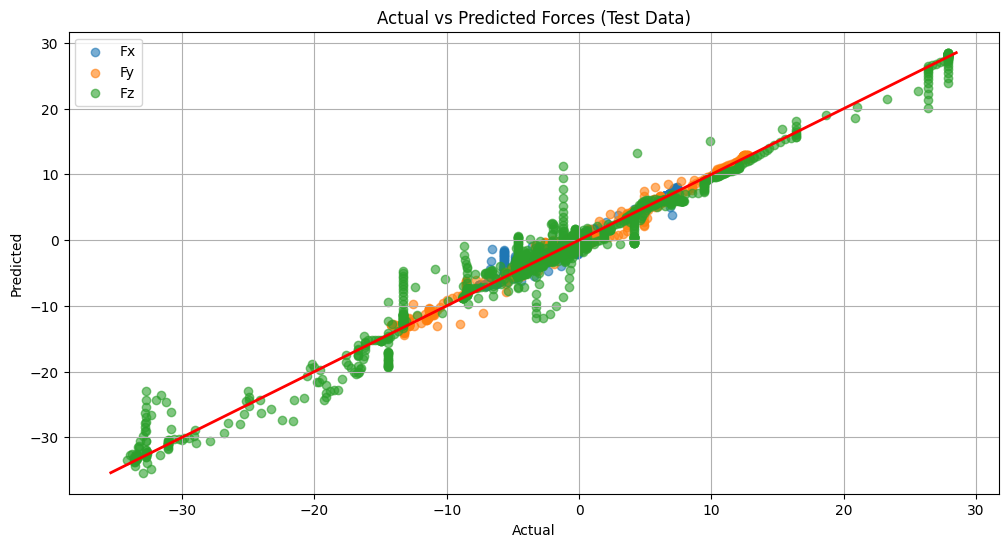

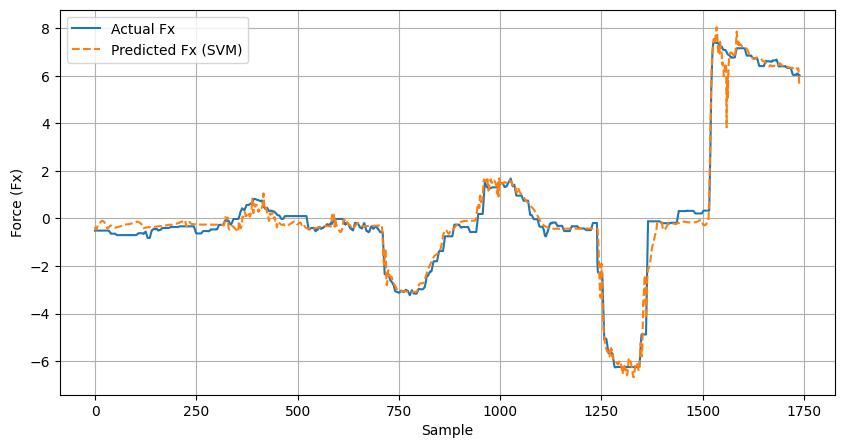

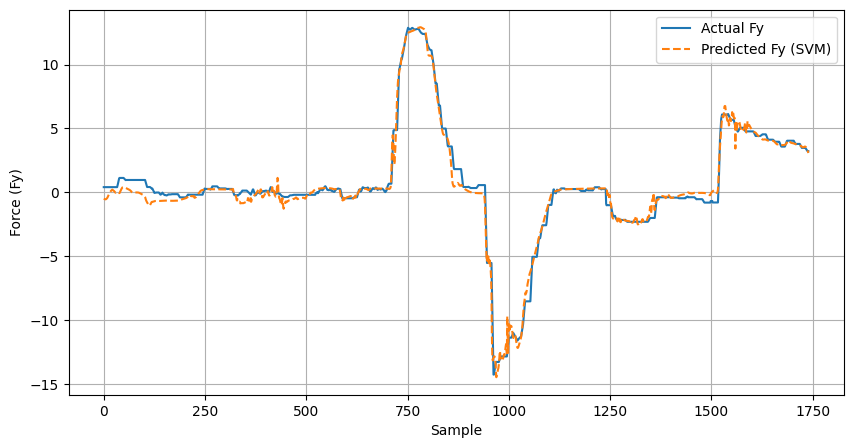

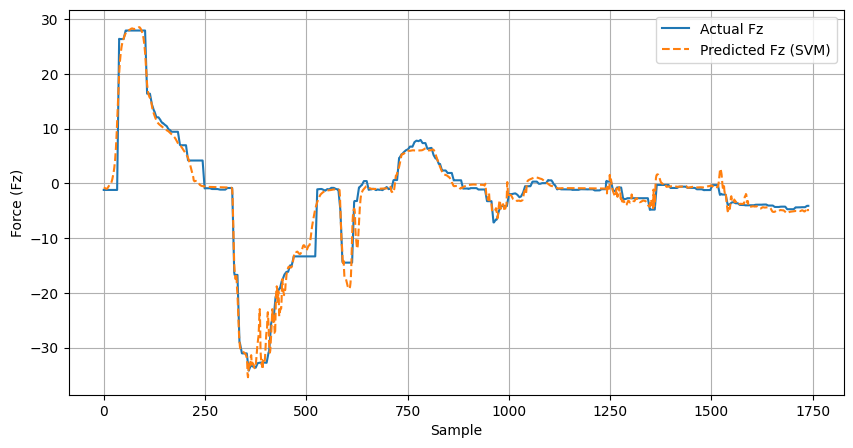

In [21]:
from tensorflow.keras.models import load_model  # Tambahkan ini untuk mengimpor load_model

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# 1. Load dataset untuk pengujian
test_data = pd.read_excel('dataUji.xlsx')  # Ganti dengan nama file dataset uji Anda

# Input (medan magnet) dan output (gaya pada tiga sumbu)
X_test = test_data[['Magx', 'Magy', 'Magz']].values
y_test = test_data[['Fx', 'Fy', 'Fz']].values

# 2. Load scaler dan normalisasi data uji
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_test_seq, y_test_seq = [], []

for i in range(len(X_test_scaled) - time_steps):
    X_test_seq.append(X_test_scaled[i:i + time_steps])
    y_test_seq.append(y_test_scaled[i + time_steps])

X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# 3. Load model LSTM dan ekstrak fitur
lstm_model = load_model('lstm_model.h5')

# Ekstraksi fitur dari model LSTM
test_features = lstm_model.predict(X_test_seq)

# 4. Load model SVM untuk setiap sumbu gaya
svm_fx = joblib.load('svm_fx.pkl')
svm_fy = joblib.load('svm_fy.pkl')
svm_fz = joblib.load('svm_fz.pkl')

# Prediksi dengan model SVM
pred_fx_scaled = svm_fx.predict(test_features)
pred_fy_scaled = svm_fy.predict(test_features)
pred_fz_scaled = svm_fz.predict(test_features)

# 5. Inverse transform prediksi dan nilai aktual
y_pred_scaled = np.stack([pred_fx_scaled, pred_fy_scaled, pred_fz_scaled], axis=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_seq)

# 6. Evaluasi model
mse_fx = mean_squared_error(y_test_original[:, 0], y_pred[:, 0])
mse_fy = mean_squared_error(y_test_original[:, 1], y_pred[:, 1])
mse_fz = mean_squared_error(y_test_original[:, 2], y_pred[:, 2])

r2_fx = r2_score(y_test_original[:, 0], y_pred[:, 0])
r2_fy = r2_score(y_test_original[:, 1], y_pred[:, 1])
r2_fz = r2_score(y_test_original[:, 2], y_pred[:, 2])

print(f'MSE Fx: {mse_fx}, R² Fx: {r2_fx}')
print(f'MSE Fy: {mse_fy}, R² Fy: {r2_fy}')
print(f'MSE Fz: {mse_fz}, R² Fz: {r2_fz}')

# 7. Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original[:, 0], y_pred[:, 0], label='Fx', alpha=0.6)
plt.scatter(y_test_original[:, 1], y_pred[:, 1], label='Fy', alpha=0.6)
plt.scatter(y_test_original[:, 2], y_pred[:, 2], label='Fz', alpha=0.6)
plt.plot([min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())],
         [min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())],
         color='red', linewidth=2)
plt.title('Actual vs Predicted Forces (Test Data)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()
plt.show()

# Visualisasi untuk setiap sumbu
plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 0], label='Actual Fx')
plt.plot(y_pred[250:2000, 0], label='Predicted Fx (SVM)', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fx)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 1], label='Actual Fy')
plt.plot(y_pred[250:2000, 1], label='Predicted Fy (SVM)', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fy)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 2], label='Actual Fz')
plt.plot(y_pred[250:2000, 2], label='Predicted Fz (SVM)', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fz)')
plt.legend()
plt.grid()
plt.show()
